In [1]:
#source: https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb

# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np


bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [ ]:
class VAE(nn.Module):
  def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
    super(VAE, self).__init__()
    
    self.z_dim = z_dim

    # encoder part
    self.fc1 = nn.Linear(x_dim, h_dim1)
    self.fc2 = nn.Linear(h_dim1, h_dim2)
    self.fc31 = nn.Linear(h_dim2, z_dim)
    self.fc32 = nn.Linear(h_dim2, z_dim)
    # decoder part
    self.fc4 = nn.Linear(z_dim, h_dim2)
    self.fc5 = nn.Linear(h_dim2, h_dim1)
    self.fc6 = nn.Linear(h_dim1, x_dim)
      
  def encoder(self, x):
    h = F.relu(self.fc1(x))
    h = F.relu(self.fc2(h))
    return self.fc31(h), self.fc32(h)
  
  def sampling(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)
      
  def decoder(self, z):
    h = F.relu(self.fc4(z))
    h = F.relu(self.fc5(h))
    return F.sigmoid(self.fc6(h)) 
  
  def forward(self, x):
    mu, log_var = self.encoder(x.view(-1, 784))
    z = self.sampling(mu, log_var)
    return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 256, h_dim2=128, z_dim=2)
if torch.cuda.is_available():
  vae.cuda()
if torch.xpu.is_available():
  vae.xpu()

print('total parameters: ', sum([p.numel() for p in vae.parameters()]))

total parameters:  469268


In [3]:
def view_samples(vae, z_dim=2):
  with torch.no_grad():
    z = torch.randn(64, z_dim).xpu()
    sample = vae.decoder(z)
    sample = sample.view(-1, 28, 28).cpu()
  
  img_list = torch.unbind(sample, dim=0)
  num_rows = 8
  num_cols = 8
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols/2, num_rows/2)) # Adjust figsize as needed
  for i in range(num_rows):
    for j in range(num_cols):
      index = i * num_cols + j # Calculate index for your image data
      if index < len(img_list): # Check if you have enough images
        ax = axes[i, j] # Get the current axis
        ax.imshow(img_list[index], cmap='grey') # Display the image
        ax.axis('off') # Turn off axes for cleaner display
      else:
        # If you have fewer images than subplots, turn off empty axes
        axes[i, j].axis('off')
  plt.tight_layout(pad=0) # Adjust subplot parameters for a tight layout
  plt.show() # Display the plot"

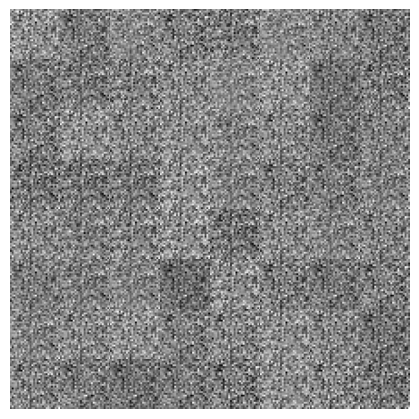

In [4]:
view_samples(vae, 2)

In [8]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var, scale_BCE=1.0, scale_KLD=1.0):
  BCE = scale_BCE * F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
  KLD = scale_KLD * -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return BCE, KLD

In [46]:
def train(epoch):
  vae.train()
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.xpu()
    optimizer.zero_grad()
    
    recon_batch, mu, log_var = vae(data)
    BCE, KLD = loss_function(recon_batch, data, mu, log_var, scale_KLD=10.0)
    loss = BCE + KLD
    
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    
    if batch_idx % 200 == 0:
      print(
        f'''Train Epoch: {epoch} [{batch_idx}/{len(data)}] Loss: {loss.item()/len(data):.4f}, BCE Loss: {BCE.item()/len(data):.4f}, KLD Loss: {KLD.item()/len(data):.4f}''')
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [47]:
def test():
  vae.eval()
  test_loss= 0
  with torch.no_grad():
    for data, _ in test_loader:
      data = data.xpu()
      recon, mu, log_var = vae(data)
      
      # sum up batch loss
      BCE, KLD = loss_function(recon, data, mu, log_var)
      test_loss += (BCE + KLD).item()
      
  test_loss /= len(test_loader.dataset)
  print('====> Test set loss: {:.4f}'.format(test_loss))

Train Epoch: 1 [0/100] Loss: 183.9198, BCE Loss: 161.0982, KLD Loss: 22.8216
Train Epoch: 1 [200/100] Loss: 196.1051, BCE Loss: 171.6062, KLD Loss: 24.4989
Train Epoch: 1 [400/100] Loss: 192.7368, BCE Loss: 168.4244, KLD Loss: 24.3124
====> Epoch: 1 Average loss: 188.5909
====> Test set loss: 163.4645
Train Epoch: 2 [0/100] Loss: 191.0400, BCE Loss: 163.6285, KLD Loss: 27.4115
Train Epoch: 2 [200/100] Loss: 193.4088, BCE Loss: 166.9591, KLD Loss: 26.4497
Train Epoch: 2 [400/100] Loss: 187.2931, BCE Loss: 160.8951, KLD Loss: 26.3980
====> Epoch: 2 Average loss: 187.1055
====> Test set loss: 160.9665
Train Epoch: 3 [0/100] Loss: 176.6197, BCE Loss: 150.3978, KLD Loss: 26.2219
Train Epoch: 3 [200/100] Loss: 182.2308, BCE Loss: 154.0348, KLD Loss: 28.1960
Train Epoch: 3 [400/100] Loss: 188.0177, BCE Loss: 159.5283, KLD Loss: 28.4894
====> Epoch: 3 Average loss: 186.3203
====> Test set loss: 159.8123
Train Epoch: 4 [0/100] Loss: 187.8985, BCE Loss: 159.4142, KLD Loss: 28.4843
Train Epoch: 4

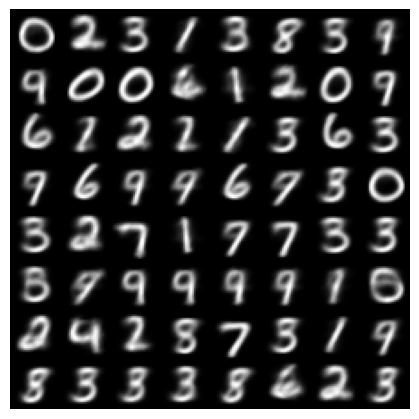

In [49]:
for epoch in range(1, 10):
  train(epoch)
  test()
view_samples(vae, 2)

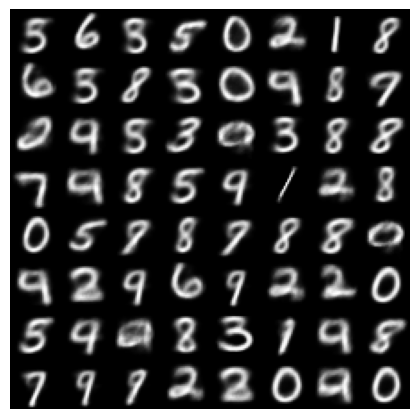

In [24]:
with torch.no_grad():
  z = torch.randn(64, 2)#.cuda()
  vae.xpu()
  #sample = vae.decoder(z)#.cuda()
  
  #save_image(sample.view(64, 1, 28, 28), './generated_vae_images/sample_' + '.png')
  view_samples(vae)

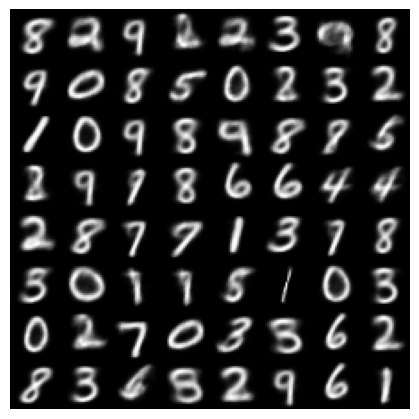

In [25]:

with torch.no_grad():
  z = torch.randn(64, 2)#.cuda()
  vae.cpu()
  sample = vae.decoder(z)#.cuda()
  sample = sample.view(-1, 28, 28)
img_list = torch.unbind(sample, dim=0)

num_rows = 8
num_cols = 8
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols/2, num_rows/2)) # Adjust figsize as needed
for i in range(num_rows):
  for j in range(num_cols):
    index = i * num_cols + j # Calculate index for your image data
    if index < len(img_list): # Check if you have enough images
      ax = axes[i, j] # Get the current axis
      ax.imshow(img_list[index], cmap='grey') # Display the image
      ax.axis('off') # Turn off axes for cleaner display
    else:
      # If you have fewer images than subplots, turn off empty axes
      axes[i, j].axis('off')
plt.tight_layout(pad=0) # Adjust subplot parameters for a tight layout
plt.show() # Display the plot

### Visualizing 2D latent space

In [12]:
dataiter = iter(train_loader)
X, y = next(dataiter)
X = X.xpu()

In [50]:
recon_batch, mu, log_var = vae(X)
mu, log_var = mu.cpu().detach().numpy(), log_var.cpu().detach().numpy() #move to cpu

In [51]:
mu.shape, log_var.shape

((100, 2), (100, 2))

In [52]:
y.shape, y.device, y

(torch.Size([100]),
 device(type='cpu'),
 tensor([8, 2, 4, 0, 5, 1, 0, 3, 9, 7, 0, 3, 2, 1, 1, 0, 3, 7, 8, 2, 8, 5, 7, 6,
         4, 8, 7, 0, 2, 7, 3, 4, 6, 7, 1, 2, 5, 7, 9, 0, 1, 6, 2, 5, 7, 0, 8, 1,
         1, 3, 5, 5, 8, 4, 9, 1, 7, 7, 3, 2, 1, 8, 1, 8, 3, 9, 5, 8, 8, 0, 5, 9,
         5, 2, 8, 2, 1, 2, 9, 0, 0, 3, 7, 0, 4, 5, 9, 9, 6, 2, 6, 2, 1, 7, 7, 3,
         7, 9, 5, 9]))

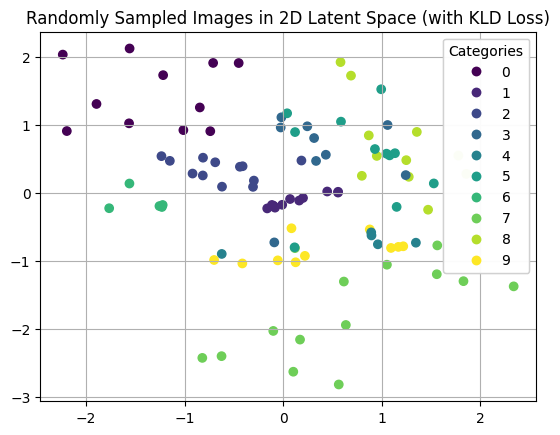

In [55]:
fig, ax = plt.subplots()
scatter = ax.scatter(mu[:, 0], mu[:, 1], c=y, cmap='viridis')

legend1 = ax.legend(*scatter.legend_elements(), title="Categories")

# Add the legend to the axes
ax.add_artist(legend1) 

# Optional: Add grid and title
ax.grid(True)
ax.set_title("Randomly Sampled Images in 2D Latent Space (with KLD Loss)")

plt.show()

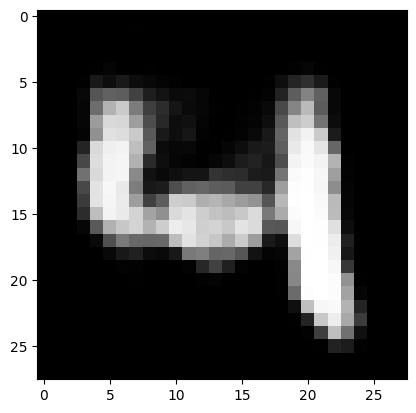

In [ ]:
#l = [10.0, -5.0]
#l = [5.0, -25.0]
l = [0.0, 0.0]
l = [-10.0, -10.0]
test_vect = torch.tensor(l).xpu()
decoded_test_vect = vae.decoder(test_vect).view(28, 28)
decoded_test_vect = decoded_test_vect.cpu().detach().numpy()

plt.imshow(decoded_test_vect, cmap='grey')

### Try sampling from a regular autoencoder

In [51]:
class AE(nn.Module):
  def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
    super(AE, self).__init__()
    
    self.z_dim = z_dim

    # encoder part
    self.fc1 = nn.Linear(x_dim, h_dim1)
    self.fc2 = nn.Linear(h_dim1, h_dim2)
    self.fc3 = nn.Linear(h_dim2, z_dim)
    
    # decoder part
    self.fc4 = nn.Linear(z_dim, h_dim2)
    self.fc5 = nn.Linear(h_dim2, h_dim1)
    self.fc6 = nn.Linear(h_dim1, x_dim)
      
  def encoder(self, x):
    h = F.relu(self.fc1(x))
    h = F.relu(self.fc2(h))
    return self.fc3(h)
  
  def decoder(self, z):
    h = F.relu(self.fc4(z))
    h = F.relu(self.fc5(h))
    h = F.sigmoid(self.fc6(h))
    return h

  def forward(self, x):
    embd = self.encoder(x.view(-1, 784))
    repr = self.decoder(embd)
    return embd, repr

# build model
ae = AE(x_dim=784, h_dim1= 256, h_dim2=128, z_dim=4)
if torch.cuda.is_available():
  ae.cuda()
if torch.xpu.is_available():
  ae.xpu()

print('total parameters: ', sum([p.numel() for p in ae.parameters()]))

total parameters:  469524


In [ ]:
optimizer = optim.Adam(ae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x):
  BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
  return BCE

In [54]:
def train_ae(epoch):
  ae.train()
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.xpu()
    optimizer.zero_grad()
    
    embd, repr = ae(data)
    BCE = loss_function(repr, data)
    loss = BCE
    
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    
    if batch_idx % 200 == 0:
      print(
        f'''Train Epoch: {epoch} [{batch_idx}/{len(data)}] Loss: {loss.item()/len(data):.4f}, BCE Loss: {BCE.item()/len(data):.4f}''')
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

def test_ae():
  ae.eval()
  test_loss= 0
  with torch.no_grad():
    for data, _ in test_loader:
      data = data.xpu()
      embd, repr = ae(data)
      
      # sum up batch loss
      BCE = loss_function(repr, data)
      test_loss += (BCE).item()
      
  test_loss /= len(test_loader.dataset)
  print('====> Test set loss: {:.4f}'.format(test_loss))

Train Epoch: 1 [0/100] Loss: 109.6896, BCE Loss: 109.6896
Train Epoch: 1 [200/100] Loss: 112.2531, BCE Loss: 112.2531
Train Epoch: 1 [400/100] Loss: 106.6827, BCE Loss: 106.6827
====> Epoch: 1 Average loss: 108.9101
====> Test set loss: 110.9151
Train Epoch: 2 [0/100] Loss: 109.4343, BCE Loss: 109.4343
Train Epoch: 2 [200/100] Loss: 103.0680, BCE Loss: 103.0680
Train Epoch: 2 [400/100] Loss: 110.0181, BCE Loss: 110.0181
====> Epoch: 2 Average loss: 108.5968
====> Test set loss: 110.8975
Train Epoch: 3 [0/100] Loss: 105.0155, BCE Loss: 105.0155
Train Epoch: 3 [200/100] Loss: 109.3781, BCE Loss: 109.3781
Train Epoch: 3 [400/100] Loss: 105.9627, BCE Loss: 105.9627
====> Epoch: 3 Average loss: 108.3134
====> Test set loss: 110.6654
Train Epoch: 4 [0/100] Loss: 108.4544, BCE Loss: 108.4544
Train Epoch: 4 [200/100] Loss: 109.4588, BCE Loss: 109.4588
Train Epoch: 4 [400/100] Loss: 112.8207, BCE Loss: 112.8207
====> Epoch: 4 Average loss: 108.1326
====> Test set loss: 110.7081
Train Epoch: 5 [

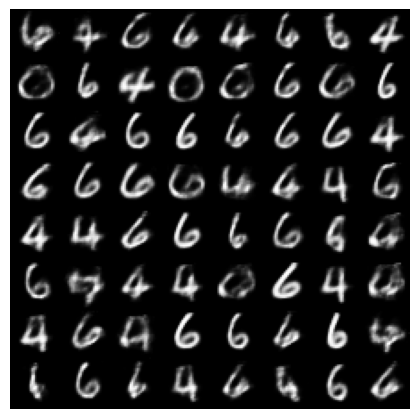

In [64]:
for epoch in range(1, 10):
  train_ae(epoch)
  test_ae()
view_samples(ae, 4)

### Single mnist digit for img demonstration

[]

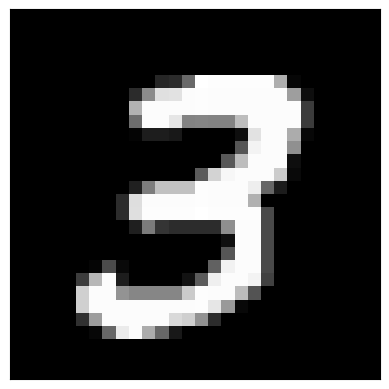

In [86]:
img, label = train_dataset.__getitem__(7)
img = img.cpu().view(28, 28).numpy()
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])